In [17]:
from bs4 import BeautifulSoup
import quopri
import pandas as pd
import numpy as np
from os import listdir
import seaborn as sns

# Making Historical Data CSV
---

In [4]:
def extract_row_data(row, dtype="current"):
    cells = row.find_all("td")
    if dtype == "current":
        return {
            "Player": cells[5].find(class_="playername").text,
            "Position": cells[4].text,
            # Some teams only have two characters, causing an extra space
            # at the start, so strip that
            "Team": cells[5].find(class_="playerTeam").text[-3:].strip(),
            "Opponent": cells[13].text,
            "Salary": cells[9].text,
            "Projection": cells[10].find("input").get("value")
        }
    elif dtype == "historical":
        # TODO: get points actually scored
            return {
                "Player": cells[5].find(class_="playername").text,
                "Position": cells[4].text,
                # Some teams only have two characters, causing an extra space
                # at the start, so strip that
                "Team": cells[5].find(class_="playerTeam").text[-3:].strip(),
                "Salary": cells[9].text,
                "Scored": cells[10].text,
                "Projection": cells[11].find("input").get("value"),
                "Consensus": cells[12].text,
                "Time": cells[13].text,
                "Opponent": cells[14].text,
                "Order": cells[16].text,
                "Bat/Arm": cells[17].text,
                "Consistent": cells[18].text,
                "Floor": cells[19].text,
                "Ceiling": cells[20].text,
                "Avg FP": cells[22].text,
                "Imp Runs": cells[23].text,
                "pOwn": cells[25].text,
                "actOwn": cells[26].text,
                "Leverage": cells[27].text,
                "Safety": cells[28].text
            }


def extract_linestar_data(filename, dtype="current"):
    html = open(filename, "r")
    html = quopri.decodestring(html.read())
    soup = BeautifulSoup(html)
    
    table = soup.find_all("table")[0]
    row_data = []
    for row in table.find_all("tr", class_="playerCardRow"):
        row_data.append(extract_row_data(row, dtype))
    
    return pd.DataFrame(row_data)

In [5]:
frames = []
for file in listdir("./data"):
    frame = extract_linestar_data("./data/" + file, dtype="historical")
    frame["Date"] = file[:10]
    frames.append(frame)

KeyboardInterrupt: 

In [7]:
data = extract_linestar_data("./data/2022-05-17.mhtml", dtype="historical")

In [8]:
#data = pd.concat(frames)
# Remove (R) and (L) from pither names
data.loc[data["Position"] == "P", "Player"] = data.loc[data["Position"] == "P", "Player"].str[:-4]
data["Salary"] = data["Salary"].replace("[\$,]", "", regex=True).astype(int)
data["Projection"] = data["Projection"].astype(float)
data["Scored"] = data["Scored"].astype(float)
data[["pOwn", "actOwn"]] = data[["pOwn", "actOwn"]].replace("[\%]", "", regex=True).astype(float)
data["Position"] = data["Position"].str.split("/", expand=True)[0]
# Replace players with no batting order with NaN
data["Order"] = data["Order"].replace({"-": np.nan})

In [5]:
data.to_csv("linestar_data.csv", index=False)

# Correlation Matrix
---

In [3]:
data = pd.read_csv("linestar_data.csv")

data["Opposing Pitcher"] = data.loc[data["Position"] != "P", "Opponent"].str.split(",", expand=True)[0]

### Batting Order

In [7]:
batters = data[data["Position"] != "P"]

In [12]:
order_scored = batters.groupby(["Date", "Team", "Order"]).sum()["Scored"]

In [15]:
corr = order_scored.unstack().corr()

<AxesSubplot:xlabel='Order', ylabel='Order'>

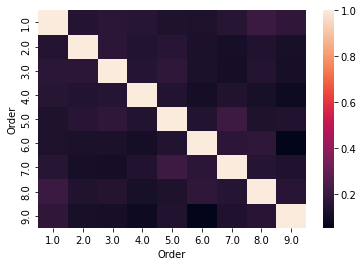

In [18]:
sns.heatmap(corr)

In [19]:
corr

Order,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
Order,,,,,,,,,
1.0,1.000000,0.141999,0.160298,0.151876,0.128256,0.123804,0.150353,0.198005,0.171812
2.0,0.141999,1.000000,0.161247,0.138864,0.156243,0.123329,0.109134,0.137675,0.115137
3.0,0.160298,0.161247,1.000000,0.146838,0.171252,0.123079,0.106483,0.144186,0.110921
4.0,0.151876,0.138864,0.146838,1.000000,0.138358,0.107613,0.137265,0.113940,0.085090
5.0,0.128256,0.156243,0.171252,0.138358,1.000000,0.138263,0.205045,0.130159,0.137002
6.0,0.123804,0.123329,0.123079,0.107613,0.138263,1.000000,0.163259,0.171186,0.053083
7.0,0.150353,0.109134,0.106483,0.137265,0.205045,0.163259,1.000000,0.147238,0.131273
8.0,0.198005,0.137675,0.144186,0.113940,0.130159,0.171186,0.147238,1.000000,0.155895
9.0,0.171812,0.115137,0.110921,0.085090,0.137002,0.053083,0.131273,0.155895,1.000000


In [48]:
corr.to_csv("batting_order_corr.csv")

### Opposing Pitcher

In [28]:
pitchers = data[data["Position"] == "P"]

In [43]:
batters = batters.merge(pitchers[["Player", "Date", "Scored"]],
                        left_on=["Date", "Opposing Pitcher"],
                        right_on=["Date", "Player"],
                        how="left",
                        suffixes=[None, " Opposing"]
                       )

In [49]:
corr = batters[["Scored", "Scored Opposing"]].corr()

In [50]:
corr

,Scored,Scored Opposing
Scored,1.000000,-0.307066
Scored Opposing,-0.307066,1.000000


In [51]:
corr.to_csv("opp_pitcher_corr.csv")